In [1]:
import pandas as pd
import os
pd.set_option('display.max_columns',None)
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
organizations = pd.read_csv('../CRUNCHBASE_DATA/bulk_export/organizations.csv')

In [4]:
organizations['founded_on'] = pd.to_datetime(organizations['founded_on'],errors='coerce')

In [5]:
funding_rounds = pd.read_csv('../CRUNCHBASE_DATA/bulk_export/funding_rounds.csv')

# Формирование таргета

Сейчас рассматриваем бейзлайн модель. Таргет будем формировать как в нескольких статьях, на которые обращали внимание (обзоры есть в моем notion).

В единичку будем записывать те компании, которые получили IPO, ACQ, ROUND A или B.

In [6]:
ipos = pd.read_csv('../CRUNCHBASE_DATA/bulk_export/ipos.csv')
#ipos['went_public_on'] = pd.to_datetime(ipos['went_public_on'])
#ipos = ipos[ipos.went_public_on>'2010-01-01']

acquisitions = pd.read_csv('../CRUNCHBASE_DATA/bulk_export/acquisitions.csv')
#acquisitions['acquired_on'] = pd.to_datetime(acquisitions['acquired_on'])
#acquisitions = acquisitions[acquisitions.acquired_on>'2010-01-01']

In [7]:
organizations.status.value_counts()# Всего уникальных меток статуса

operating    1779970
closed        138475
acquired      113284
ipo            41277
Name: status, dtype: int64

Тут наверное сразу нужно продемонстрировать одну вещь. Она говорит о том, что данные в базе обновляются (что логично). Но с помощью доп. табличек можно вытащить историческую информацию.

Ниже пример. Мы берем компании из acquisitions.csv. И смотрим на их актуальный статус в таблице организаций. Видно что около 10% компаний, которые были приобретены - закрылись.

С IPO следующая картина - подавляющее большинство компаний остались в статусе IPO. Немного были приобретены и совсем малая часть закрылась.

In [8]:
organizations[organizations.uuid.isin(acquisitions.acquiree_uuid)]['status'].value_counts()

acquired    113281
closed       15279
Name: status, dtype: int64

In [9]:
organizations[organizations.uuid.isin(ipos.org_uuid)]['status'].value_counts()

ipo         41277
acquired     3511
closed       1685
Name: status, dtype: int64

Я предлагаю компании, которые были образованы не ранее 2005 года. 

В одной статье берут в рассмотрение данные с 1995 года. Мне кажется что туда довольно много мусора попадает. Плюс самая ранняя запись в таблице организаций `Timestamp('2007-05-25 13:51:27').` То есть это начала существования базы данных CB.

Плюс мы ислючаем доткомовский пузырь. Он вроде в 2000 закончился.

Проблема в том, что около 20 процентов компаний не имеют даты основания.

In [10]:
organizations['founded_on'].isnull().value_counts()

False    1608707
True      464299
Name: founded_on, dtype: int64

In [11]:
null_founded_org = organizations[organizations['founded_on'].isnull()]

In [12]:
null_founded_org.shape

(464299, 41)

In [13]:
null_founded_org['status'].value_counts()

operating    408174
closed        30436
acquired      21636
ipo            4053
Name: status, dtype: int64

Давайте посмотрим есть ли по этим компаниями хоть какая то информация по смежным таблицам.

Пересечение с ACQ или IPO небольшое.

In [14]:
null_founded_org[null_founded_org.uuid.isin(acquisitions.acquiree_uuid)|null_founded_org.uuid.isin(ipos.org_uuid)].shape

(27375, 41)

Пересечение с funding_rounds еще меньше.

In [15]:
null_founded_org[null_founded_org.uuid.isin(funding_rounds.org_uuid)].shape

(11433, 41)

В общем есть ощущение, что раз уж по этим компаниям мы пока что не можем получить никакой информации - стоит убрать их рассмотрения. Потому что по сути мы никак не можем положить их на временную шкалу.

In [16]:
organizations = organizations[~organizations['founded_on'].isnull()]

In [17]:
organizations.shape

(1608707, 41)

Возьмем организации у которых статус acquired/ipo.

In [18]:
acq_or_ipo = organizations[organizations.status.isin(['acquired','ipo'])]

In [19]:
acq_or_ipo.shape

(128872, 41)

Теперь добавим к ним те, которые получили интересующие нас раунды финансирования.

Я беру A и B.

In [20]:
ones_rounds = funding_rounds[funding_rounds.investment_type.isin(['series_a', 'series_b'])]

Можно убрать тех, по которым неизвестна сумма поднятых денег, но пока не будем. Потому что по тем, которые IPO и ACQ ОЧЕНЬ много пропущенных значенмй в графе поднятных денег.

In [21]:
ipos[ipos.org_uuid.isin(acq_or_ipo.uuid)]['money_raised'].isnull().value_counts()

True     36445
False     5460
Name: money_raised, dtype: int64

In [22]:
ipos[ipos.org_uuid.isin(acq_or_ipo.uuid)]['valuation_price'].isnull().value_counts()

True     39079
False     2826
Name: valuation_price, dtype: int64

In [23]:
acquisitions[acquisitions.acquiree_uuid.isin(acq_or_ipo.uuid)]['price'].isnull().value_counts()

True     81513
False    18031
Name: price, dtype: int64

В [этой](https://reader.elsevier.com/reader/sd/pii/S0306457321000595?token=9C3DE156C6650E543E8D51256AA926CC399481A33D96891B33889A8501C1D6D86FF7CA35FA5859C18E9EBBF79DFD3B05&originRegion=eu-west-1&originCreation=20220616162446) статье в нолики записывают все остальные компании, кроме вышеперечисленных. То есть единички - это ACQ, IPO, A и B. Я считаю что это в корне неправильно.

Да, окей, у нас есть closed компании. Но остальные operating компании имеют статус в funding rounds - один из огромной таблицы.

Ниже пример. Мы взяли компании со статусом operating - то есть это те компании, у которых не IPO и не acquisition. По ним нашли funding rounds. И ниже табличка с частотностью типов фандинга для этих компаний.

То есть компания может быть opearing, что фандинг раунд у нее grant или вообще post_ipo_debt.

In [24]:
operating = organizations[organizations.status=='operating']

In [25]:
funding_rounds[funding_rounds.org_uuid.isin(operating.uuid)]['investment_type'].value_counts()

seed                     100347
series_unknown            48228
series_a                  37315
pre_seed                  30013
grant                     25186
angel                     18485
series_b                  16190
debt_financing            12795
non_equity_assistance      9714
private_equity             9252
convertible_note           7186
series_c                   6620
equity_crowdfunding        5929
undisclosed                5342
corporate_round            3612
series_d                   2630
series_e                   1008
product_crowdfunding        952
secondary_market            871
initial_coin_offering       698
series_f                    351
series_g                    122
post_ipo_equity              97
series_h                     44
series_i                     16
post_ipo_debt                14
series_j                     12
post_ipo_secondary            2
Name: investment_type, dtype: int64

In [26]:
operating_funding = funding_rounds[funding_rounds.org_uuid.isin(operating.uuid)]

In [27]:
operating_funding['announced_on'] = pd.to_datetime(operating_funding['announced_on'])

/var/folders/w6/5q18n8_j5pd3kvgw25svnzb80000gp/T/ipykernel_1490/2525953834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  operating_funding['announced_on'] = pd.to_datetime(operating_funding['announced_on'])


In [28]:
operating_funding['announced_on'].value_counts()[:10]

2019-01-01    2868
2018-01-01    1847
2020-01-01    1814
2016-01-01    1719
2017-01-01    1700
2015-01-01    1469
2021-01-01    1402
2014-01-01    1300
2018-06-01     947
2017-06-01     934
Name: announced_on, dtype: int64

Text(0.5, 1.0, 'number of announced funding by year')

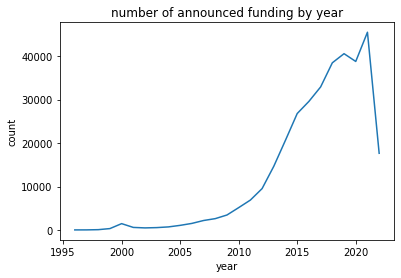

In [29]:
operating_funding['announced_on'].dt.year.value_counts().sort_index()[30:].plot()
plt.xlabel('year')
plt.ylabel('count')
plt.title('number of announced funding by year')

In [30]:
A_B_series = operating_funding[operating_funding['investment_type'].isin(['series_a', 'series_b'])]

In [31]:
A_B_series.shape

(53505, 24)

In [32]:
A_B_series['org_uuid'].nunique()

35322

In [403]:
A_B_series['raised_amount_usd'].isnull().value_counts()


False    44433
True      9072
Name: raised_amount_usd, dtype: int64

Теперь возьмем из организаций компании, которые получили интересующие нас раунды.

In [33]:
A_B_companies = operating[operating.uuid.isin(A_B_series.org_uuid)]

### Единички
теперь соберем в единички все что мы обработали ранее, это:
* Компании которые вышли на IPO или ACQ (organizations.status == ipo|acquired)
* Для тех, у кого статус приобретения равен operating - берем те, у которых round a или b

И затем отрежем до тех компаний, которые были образованы не ранее 2005 года.

Большую часть нашего датасета составляют компании, которые вышли на IPO или ACQ. Что вообще говоря странно, но пока не знаю как правильно это поправить.

In [49]:
ones_companies = pd.concat([A_B_companies,acq_or_ipo])

In [50]:
ones_companies.shape

(164194, 41)

In [51]:
ones_companies['status'].value_counts()

acquired     91648
ipo          37224
operating    35322
Name: status, dtype: int64

In [52]:
ones_companies = ones_companies[ones_companies.founded_on>'2005-01-01']

После отрезания по времени у нас остается вдвое меньше компаний.

In [43]:
ones_companies.shape

(72980, 41)

Зато немного сместился баланс в пользу operating компаний, что тоже вполне логично. Чем ближе мы приближаемся по временной шкале к текущему моменту, тем больше у нас молодых компаний, которые находятся только в стадии инвестирования.

In [54]:
ones_companies['status'].value_counts()

acquired     32233
operating    31366
ipo           9381
Name: status, dtype: int64

В данных по org есть поле roles. Смысл понятено из уникальных значений. 

In [58]:
organizations['roles'].unique()

array(['company', 'investor,company', 'investor', 'company,investor',
       'investor,company,school', 'investor,school', 'school',
       'company,school', 'school,company', 'school,investor', nan,
       'school,company,investor', 'company,investor,school'], dtype=object)

Если посмотреть распределение среди наших единичек, то получается следующая картина. Оставим только те, у которых роль - company. На всякий случай. Много информации не потеряем.

In [59]:
ones_companies['roles'].value_counts()

company                    69877
investor,company            2343
company,investor             261
investor                     175
school                        20
investor,company,school       17
company,school                11
investor,school                1
school,company,investor        1
school,company                 1
Name: roles, dtype: int64

In [60]:
ones_companies = ones_companies[ones_companies['roles']=='company']

Ну с заполненной историей по количеству раундов финансирования и привлеченному капиталу конечно все грустно. Примерно 30% пропущенных значений остается.

In [61]:
ones_companies.num_funding_rounds.isnull().value_counts()

False    45544
True     24333
Name: num_funding_rounds, dtype: int64

In [62]:
ones_companies.total_funding_usd.isnull().value_counts()

False    45543
True     24334
Name: total_funding_usd, dtype: int64

### Нолики.

Теперь более сложная часть, будем готовить нолики. Для начала отфильтруем организации с 2005 года и уберем уже готовые единички.

In [65]:
zero_companies = organizations[organizations.founded_on>'2005-01-01']

In [68]:
zero_companies = zero_companies[~zero_companies.uuid.isin(ones_companies.uuid)]

In [74]:
zero_companies['status'].value_counts()

operating    714453
closed        84424
ipo             956
acquired        934
Name: status, dtype: int64

По организациями, у которых статус  closed большинство пропущенных значений по дате закрытия. Это и логично, такую информацию трудно достать. С другой стороны, интересно, как они определяет то, что компания закрылась.

Пока что непонятно, как это правильно верифицировать, так что просто давайте добавим все компании со статусом closed в нолики.

In [75]:
closed = zero_companies[zero_companies.status=='closed']

In [76]:
closed['closed_on'].isnull().value_counts()

True     69020
False    15404
Name: closed_on, dtype: int64

In [79]:
closed = closed[closed['roles']=='company']

В статье делали так, что ВСЕ ЧТО НЕ ЕДИНИЧКИ (IPO/ACQ/ROUND A/B) считают за нолики. Так у них получалось 87 процентов ноликов.


Но я считаю что это совсем неверный подход. Потому что в итоге в нолики идут очень много компаний со статусом operating, и статус фандинга у них может быть супер разный. 

То есть грубо говоря, у них в нолики попадают и seed и post_ipo_equity. Поэтому бейзлайн модель я бы все таки строил на статусе closed.

Следующую итерация разработки модели уже строил бы совершенно с другого подхода - надо смотреть компании на временной шкале, и определять, по каким из них давно нет информации - скорее всего это будут мертвые компании.

В общем текущий бейзлайн строится на "чистых лейблах".

In [117]:
closed.shape

(81610, 41)

# Features

Давайте построим простую модель.

In [237]:
closed['label'] = 0
ones_companies['label'] = 1

/var/folders/w6/5q18n8_j5pd3kvgw25svnzb80000gp/T/ipykernel_1490/644280198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed['label'] = 0


In [238]:
all_data = pd.concat([closed,ones_companies])

* Я не добавляю в таблицу фичу RANK, потому что она заглядывает в будущее. Ее будем использовать в следующих итерациях моделей. Это изменяющаяся по времени фича.

In [239]:
all_data.head()

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,legal_name,roles,domain,homepage_url,country_code,state_code,region,city,address,postal_code,status,short_description,category_list,category_groups_list,num_funding_rounds,total_funding_usd,total_funding,total_funding_currency_code,founded_on,last_funding_on,closed_on,employee_count,email,phone,facebook_url,linkedin_url,twitter_url,logo_url,alias1,alias2,alias3,primary_role,num_exits,label
8,60485007-8856-bbac-aa1b-c535c41f5f47,Omnidrive,organization,omnidrive,https://www.crunchbase.com/organization/omnidrive,1232919.0,2007-05-27 10:25:32,2019-10-03 06:30:53,NaN,company,omnidrive.com,http://www.omnidrive.com,USA,CA,California,Palo Alto,Suite 200 654 High Street,94301,closed,Omnidrive provides online storage facilities t...,"E-Commerce,File Sharing,Internet,Social Media,...","Commerce and Shopping,Internet Services,Media ...",1.0,800000.0,800000.0,USD,2005-11-01,2006-12-01,2008-09-15,unknown,info@omnidrive.com,NaN,http://www.facebook.com/Nomadesk,NaN,http://twitter.com/Nomadesk,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN,0
24,56e82b22-7466-b00b-9035-57ad7b584f65,Helio Pur Technologies,organization,helio,https://www.crunchbase.com/organization/helio,208652.0,2007-06-06 04:39:53,2022-06-02 08:24:44,NaN,company,helio.com,http://www.helio.com,USA,CA,California,Los Angeles,10960 Wilshire Blvd. Suite 700,90024,closed,"Helio, a mobile service that targets multimedi...","Internet,Mobile,Telecommunications","Hardware,Internet Services,Mobile",NaN,NaN,NaN,NaN,2005-02-01,NaN,NaN,251-500,NaN,NaN,NaN,https://www.linkedin.com/company/helio/,NaN,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN,0
26,7ac8de1f-61b5-b1e8-d67d-6983e765b0cf,Wis.dm,organization,wis-dm,https://www.crunchbase.com/organization/wis-dm,1000099.0,2007-06-07 14:07:52,2018-02-13 00:01:42,NaN,company,wis.dm,http://wis.dm,USA,IL,Illinois,Chicago,NaN,NaN,closed,Wis.dm is a social network based around simple...,"Advertising,Big Data,Online Portals,Social Med...","Advertising,Data and Analytics,Internet Servic...",1.0,5000000.0,5000000.0,USD,2006-06-01,2007-08-01,2012-01-01,unknown,NaN,NaN,NaN,NaN,http://twitter.com/wis_dm,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN,0
30,90e234e5-c045-f851-e6aa-291af5d270fe,Joost,organization,joost,https://www.crunchbase.com/organization/joost,196994.0,2007-06-09 14:05:30,2022-04-18 08:18:11,NaN,company,joost.com,http://joost.com,USA,NY,New York,New York,100 5th Ave Fl 6,10011-6903,closed,Joost is an internet TV service that uses peer...,"Internet,TV,Video","Internet Services,Media and Entertainment,Video",1.0,45000000.0,45000000.0,USD,2006-10-01,2007-05-09,NaN,501-1000,newyork@joost.com,NaN,NaN,NaN,NaN,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN,0
37,6ec85818-e24d-4789-660e-9cda11bb86fa,Babelgum,organization,babelgum,https://www.crunchbase.com/organization/babelgum,696577.0,2007-06-09 15:15:21,2019-06-24 22:01:07,NaN,company,babelgum.com,http://babelgum.com,IRL,NaN,Dublin,Dublin,Block J Eastpoint Business Park Clontarf,NaN,closed,Babelgum is a free integrated web and mobile v...,"Content,Mobile,Video,Web Development","Media and Entertainment,Mobile,Software,Video",1.0,13200000.0,13200000.0,USD,2005-06-01,2007-03-05,2013-01-09,101-250,info@babelgum.com,NaN,NaN,NaN,http://twitter.com/Babelgum,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN,0


In [240]:
all_data['is_legal_name'] = all_data['legal_name'].isnull()# заполнено ли поле legal_name
all_data['is_homepage_url'] = all_data['homepage_url'].isnull()# заполнено ли поле homepage_url

In [241]:
from sklearn.preprocessing import LabelEncoder

In [242]:
country_le = LabelEncoder()
all_data['country_code'] = country_le.fit_transform(all_data['country_code'])

### category_list

Это один из самых важных признаков в датасете. Представлен в виде строки, где через запятую перечислены области, в которых оперирует компания.

In [243]:
category_list = all_data['category_list'].dropna()

In [244]:
category_list = category_list.apply(lambda x: x.split(',')).tolist()

In [245]:
category_list[:5]

[['E-Commerce',
  'File Sharing',
  'Internet',
  'Social Media',
  'Software',
  'Web Hosting'],
 ['Internet', 'Mobile', 'Telecommunications'],
 ['Advertising',
  'Big Data',
  'Online Portals',
  'Social Media',
  'Social Network',
  'Sports'],
 ['Internet', 'TV', 'Video'],
 ['Content', 'Mobile', 'Video', 'Web Development']]

In [246]:
from collections import Counter

In [247]:
cat_counter = Counter(np.concatenate(category_list))

Всего получается 738 уникальных категорий.

Пока что будем использовать очень простой подход - возьмем первые 20 категорий, добавим 20 колонок, и проставим бинарный флаг - принадлежит ли компания к одной из этих категорий.

По хорошему конечно нужно подходить более умно к этому. Либо пропускать через какой то трансформер. Либо вручную отсмотреть все категории, и вручную составить более верхнеуровневую иерархию.

In [248]:
len(cat_counter)

738

In [249]:
cat_counter.most_common()[:20]

[('Software', 27133),
 ('Information Technology', 17924),
 ('E-Commerce', 16709),
 ('Internet', 15382),
 ('Health Care', 13236),
 ('Mobile', 9696),
 ('Advertising', 8795),
 ('Apps', 7351),
 ('Financial Services', 7175),
 ('Social Media', 6246),
 ('Manufacturing', 6241),
 ('SaaS', 5899),
 ('Education', 5809),
 ('Biotechnology', 5782),
 ('Consulting', 5474),
 ('Artificial Intelligence', 5268),
 ('Medical', 4906),
 ('Analytics', 4891),
 ('Marketing', 4837),
 ('Enterprise Software', 4489)]

In [250]:
top_cats = [i[0] for i in cat_counter.most_common()[:20]]

Плюс таким подходом у нас будут захватываться более мелкие категории, но которые содержат ключевые слова. В общем нужен список ключевых слов. Ниже пример для software

In [251]:
[i[0] for i in cat_counter.most_common() if 'Software' in i[0]]

['Software',
 'Enterprise Software',
 'Software Engineering',
 'Consumer Software',
 'Meeting Software',
 'Embedded Software',
 'Presentation Software']

In [252]:
for cat in top_cats:
    all_data[cat] = all_data['category_list'].str.contains(cat)

### category_group_list

А есть еще category_group_list. Это чуть более другая группировка. Но там меньше уникальных значений - 47. Чтобы совсем не раздувать признаковое пространство - возьмем первое значений, из перечисленных через запятую - будем считать что именно оно больше всего описывает компанию в category_group_list.

In [253]:
category_group_list = all_data['category_groups_list'].dropna()

In [254]:
category_group_list = category_group_list.apply(lambda x: x.split(',')).tolist()

In [255]:
category_group_list[:5]

[['Commerce and Shopping',
  'Internet Services',
  'Media and Entertainment',
  'Software'],
 ['Hardware', 'Internet Services', 'Mobile'],
 ['Advertising',
  'Data and Analytics',
  'Internet Services',
  'Media and Entertainment',
  'Sales and Marketing',
  'Sports'],
 ['Internet Services', 'Media and Entertainment', 'Video'],
 ['Media and Entertainment', 'Mobile', 'Software', 'Video']]

In [256]:
from collections import Counter

In [257]:
cat_group_counter = Counter(np.concatenate(category_group_list))

In [258]:
cat_group_counter

Counter({'Commerce and Shopping': 22123,
         'Internet Services': 32920,
         'Media and Entertainment': 21741,
         'Software': 53222,
         'Hardware': 15588,
         'Mobile': 15909,
         'Advertising': 9494,
         'Data and Analytics': 15328,
         'Sales and Marketing': 17272,
         'Sports': 4241,
         'Video': 4617,
         'Financial Services': 15193,
         'Gaming': 3813,
         'Payments': 3754,
         'Content and Publishing': 6661,
         'Music and Audio': 2776,
         'Navigation and Mapping': 1783,
         'Information Technology': 26264,
         'Messaging and Telecommunications': 2379,
         'Other': 14887,
         'Artificial Intelligence': 6584,
         'Professional Services': 12370,
         'Travel and Tourism': 4618,
         'Events': 2548,
         'Transportation': 7623,
         'Apps': 11034,
         'Privacy and Security': 4202,
         'Design': 8217,
         'Food and Beverage': 6220,
         'Educa

In [259]:
len(cat_group_counter)

47

In [260]:
all_data['category_groups_list'] = all_data['category_groups_list'].fillna('missed')

In [261]:
all_data['category_groups_list'] = all_data['category_groups_list'].apply(lambda x: x.split(',')[0])

In [262]:
cat_group_le = LabelEncoder()
all_data['category_groups_list'] = cat_group_le.fit_transform(all_data['category_groups_list'])

Есть несколько колонок с информацией по инвестициям, но почему то мне кажется что их лучше не включать. Потому что может быть лик.

Это колонки ['num_funding_rounds', 'total_funding_usd', 'total_funding_usd']

Есть еще колонка "founded_on" - кажется она тоже может добавить лик.
МБ потом стоит добавить колонку, например - разница в годах между выпуском из универа основателя и датой основания компании.

#### employee_count

Категориальный признак, полезный. Можно просто сделать labelencdoing

In [263]:
employee_le = LabelEncoder()

all_data['employee_count'] = employee_le.fit_transform(all_data['employee_count'])

бинарный признак указан email или нет

In [264]:
all_data['is_email'] = all_data['email'].isnull()

так же с телефоном

In [265]:
all_data['is_phone'] = all_data['phone'].isnull()

с facebook, linkedin и twitter

In [266]:
all_data['is_facebook_url'] = all_data['facebook_url'].isnull()

In [267]:
all_data['is_linkedin_url'] = all_data['linkedin_url'].isnull()

In [268]:
all_data['is_twitter_url'] = all_data['twitter_url'].isnull()

есть еще 3 колонки alias1,alias2,alias3
смысл не очень понимаю, если честно. кажется это просто альтернативные названия

In [277]:
to_drop = ['name','type','permalink','cb_url','rank','created_at','updated_at',\
           'legal_name','roles','address','postal_code','status',\
           
           
        'num_funding_rounds','total_funding','total_funding_usd','total_funding_currency_code', \
          
          
          'founded_on','last_funding_on','closed_on',\
          'phone',\
          'primary_role',
          'alias1','alias2','alias3',\
           'num_exits',
           'logo_url',\
           'short_description',\
           'city','region','state_code',\
           'homepage_url','domain',\
           'category_list',
           'facebook_url','linkedin_url','twitter_url',
           'email'
          ]

In [282]:
all_data = all_data.drop(to_drop,axis=1)

# PEOPLE 

постараемся достать информация о фаундерах

In [345]:
people = pd.read_csv('../CRUNCHBASE_DATA/bulk_export/people.csv')

In [346]:
people.head()

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,first_name,last_name,gender,country_code,state_code,region,city,featured_job_organization_uuid,featured_job_organization_name,featured_job_title,facebook_url,linkedin_url,twitter_url,logo_url
0,ed13cd36-fe2b-3707-197b-0c2d56e37a71,Ben Elowitz,person,ben-elowitz,https://www.crunchbase.com/person/ben-elowitz,28539.0,2007-05-25 14:03:54,2022-05-09 09:53:04,Ben,Elowitz,male,USA,WA,Washington,Seattle,1d845b32-7d80-47af-957d-78ccbeeaefb6,Zeitworks,Co-Founder,http://www.facebook.com/elowitz,https://www.linkedin.com/in/elowitz,http://twitter.com/elowitz,https://res.cloudinary.com/crunchbase-producti...
1,5ceca97b-493c-1446-6249-5aaa33464763,Kevin Flaherty,person,kevin-flaherty,https://www.crunchbase.com/person/kevin-flaherty,213869.0,2007-05-25 14:04:16,2018-02-12 23:14:37,Kevin,Flaherty,male,USA,WA,Washington,Mercer Island,789e5e4d-0c90-d06e-92a0-b800b461c3da,DRSmedia,Team Member,NaN,http://www.linkedin.com/in/kevinflaherty,https://twitter.com/tallkp,https://res.cloudinary.com/crunchbase-producti...
2,9f99a98a-aa97-b30b-0d36-db67c1d277e0,Raju Vegesna,person,raju-vegesna,https://www.crunchbase.com/person/raju-vegesna,9695.0,2007-05-26 02:33:03,2022-02-24 12:24:29,Raju,Vegesna,male,USA,CA,California,San Francisco,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,Chief Evangelist,NaN,https://www.linkedin.com/in/raju-vegesna-78a6541,https://twitter.com/rajuv,https://res.cloudinary.com/crunchbase-producti...
3,6e1bca72-a865-b518-b305-31214ce2d1b0,Ian Wenig,person,ian-wenig,https://www.crunchbase.com/person/ian-wenig,321152.0,2007-05-26 02:34:53,2021-03-23 10:25:04,Ian,Wenig,male,NaN,NaN,NaN,NaN,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,VP Business Development,NaN,NaN,NaN,https://res.cloudinary.com/crunchbase-producti...
4,3b598c59-7b6c-2d48-763c-da55bca77035,Owen Byrne,person,owen-byrne,https://www.crunchbase.com/person/owen-byrne,544112.0,2007-05-26 03:06:45,2022-04-08 19:52:41,Owen,Byrne,male,USA,CA,California,Mountain View,NaN,NaN,NaN,NaN,https://www.linkedin.com/in/ojbyrne,http://twitter.com/owenbyrne,https://res.cloudinary.com/crunchbase-producti...


Пока что ничего лучше для того, чтобы получить информацию о том, кто фаундер сделать не получается.

In [347]:
founders = people[people['featured_job_title'].fillna('none').str.contains('Founder')]

In [348]:
all_data_with_founders = all_data[all_data.uuid.isin(founders.featured_job_organization_uuid)]

In [349]:
founders = founders[founders.featured_job_organization_uuid.isin(all_data.uuid)]

In [350]:
founders['created_at'] = pd.to_datetime(founders['created_at'])

In [351]:
founders_not_dup = founders.drop_duplicates(subset=['featured_job_organization_uuid'],keep = 'first')

In [352]:
founders.shape

(57033, 22)

В общем в датасете из 0 и 1, собранном из компаний 150к записей. Пересечение людей из people (по сути поиск фаундеров) - 57к. То есть большинство компаний не пересекается по фаундерам.

In [353]:
founders_not_dup = founders_not_dup[['country_code','gender','uuid','featured_job_organization_uuid']]

In [354]:
founders_not_dup

,country_code,gender,uuid,featured_job_organization_uuid
5,NaN,male,80d25c23-9726-9dda-5852-39cdf4810ea5,aa3bf156-06af-5b6e-215d-9e7211fc173b
7,USA,male,084aaa07-0795-1fe8-9c46-98bbeb02cd64,c2d47d05-9e78-de77-084c-dd5171251ff1
34,ISR,male,fdf8da1c-5a58-99db-5826-cc37cf71cc8d,8af30a7e-a25c-d163-1b3a-dca317b59da2
41,USA,male,ed865d7a-f877-d1cf-51d1-a6ae901de848,21e77067-5537-408e-cad7-e5e72bb6ad86
44,USA,male,b9537d2f-73ca-b793-4434-14482d979ae5,3ce10fe3-4bfb-0db3-9ba7-5c168b65645b
...,...,...,...,...
1460995,USA,male,aaa838f3-a80a-44d2-ab05-38adcbc668ff,23a6edd6-f5e0-ae66-6782-f31603710374
1461034,GRC,male,713b0c86-9e54-4917-acb9-3a817dd4441a,75c7266e-95fe-49a3-9357-ce015525fdfe
1461112,NaN,male,d74c2ef4-a6e7-4d5e-a76d-be27f32ae79b,42af882c-9058-4a46-a986-ac2cce7e3dfd
1461137,SGP,male,c9c9d764-ec42-4489-ba87-6574b0fed493,df1284fd-e515-4d2a-b2f3-aee4e8696e9d


# DEGREES

In [355]:
degrees = pd.read_csv('../CRUNCHBASE_DATA/bulk_export/degrees.csv')

In [356]:
degrees.head()

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,person_uuid,person_name,institution_uuid,institution_name,degree_type,subject,started_on,completed_on,is_completed
0,205fdfd1-ecac-aa43-262f-219f11755f67,MS Mass Communication @ Boston University,degree,NaN,NaN,NaN,2008-02-19 17:58:31,2018-02-13 01:40:03,4897dba9-3141-ecc0-2c4b-c9d844e6440f,John Green,1eab62d2-15d9-0db7-930f-2aa77d4688e1,Boston University,MS,Mass Communication,NaN,1992-01-01,True
1,1a2ac288-eb99-3318-fde5-1517bc168f51,"BA English, French @ Washington University in...",degree,NaN,NaN,NaN,2008-02-19 17:58:31,2018-02-13 01:39:57,4897dba9-3141-ecc0-2c4b-c9d844e6440f,John Green,6ae9957a-8fb4-0ab1-73fa-dd547c4d3da4,Washington University in St. Louis,BA,"English, French",NaN,1990-01-01,True
2,b978d338-7ccc-7469-5ce7-ef98c34155ad,MS Internet Technology @ University of Greenwich,degree,NaN,NaN,NaN,2008-02-19 23:40:40,2018-02-13 01:43:09,29ea5efc-fd7a-402b-3a5d-b8660ac105ea,Sridhar Gundaiah,b5ea73f6-12a3-576d-ae9b-f4169147f974,University of Greenwich,MS,Internet Technology,NaN,2006-01-01,True
3,d01cfaad-0ccc-631e-0382-1e507bf6ba04,BS Computer Science @ Northeastern University,degree,NaN,NaN,NaN,2008-02-21 01:31:01,2018-02-13 01:43:33,45e29113-19f9-c828-68d0-42ad2ef04da0,John Furrier,5f84d9fa-78fd-14b0-d335-5ac3561cdc0a,Northeastern University,BS,Computer Science,NaN,1988-01-01,True
4,16a607f5-8ab3-573e-8d09-57b3e352e1d3,BS Computer Science @ Rochester Institute of ...,degree,NaN,NaN,NaN,2008-02-21 01:31:34,2018-02-13 01:39:53,b3b4ec6b-86fe-dd6e-ec8a-e8e7e999f274,Ian Reardon,1a380593-fb9d-7f7b-ae67-784ce3ff3690,Rochester Institute of Technology,BS,Computer Science,NaN,2002-01-01,True


Очень много уникальных значений по типо образования.

In [364]:
degrees['degree_type'].unique()

array(['MS', 'BA', 'M.A.', ..., 'Dermatology Residency Program',
       'Dermatology', 'Molecular Immunology'], dtype=object)

In [365]:
degrees['subject'].unique()

array(['Mass Communication', 'English, French', 'Internet Technology',
       ..., 'Electrical Engineering, Applied Mathematics',
       'Graphic Design and Marketing', 'Finance and Accounting, Business'],
      dtype=object)

In [357]:
degrees['degree_type'].nunique()

28867

Из 57к фаундеров, которых можно сматчить с компаниями из all_data, информация по образованию есть у 29к. То есть понижение воронки еще в 2 раза.

In [358]:
degrees = degrees[degrees.person_uuid.isin(founders.uuid)]

In [359]:
degrees.shape

(29232, 17)

In [362]:
founders.shape

(57033, 22)

Degree_type и subject потенциально полезные поля. Но заполняются не унифицировано (сверху видны примеры)

Поэтому нужно придумать какой то хитрый способ как их обрабатывать. Пока что можно просто оставить 20 самых популярных, а в ином случае проставить лейбл others.

In [366]:
top_20_degree_type = degrees['degree_type'].value_counts()[:20]

In [367]:
top_20_degree_type

MBA                    2868
BS                     2680
BA                     2119
unknown                1752
MS                     1218
PhD                     916
B.S.                    616
Bachelor                519
Ph.D                    508
B.A.                    475
BSc                     449
Ph.D.                   401
Master                  394
MSc                     389
Graduate                322
Bachelor of Science     313
BBA                     300
Degree                  295
Bachelor's Degree       278
MA                      276
Name: degree_type, dtype: int64

In [368]:
def deg_type(x):
    if x in top_20_degree_type.index:
        return x
    else:
        return 'others'

In [369]:
degrees['degree_type'] = degrees['degree_type'].apply(deg_type)

In [370]:
top_20_subjects = degrees['subject'].value_counts()[:20]

In [371]:
top_20_subjects

unknown                    3380
Computer Science           2421
Economics                   730
Electrical Engineering      673
Mechanical Engineering      485
Finance                     484
Business Administration     392
Computer Engineering        363
Marketing                   303
Business                    292
Physics                     265
Law                         247
Engineering                 188
Chemical Engineering        185
Mathematics                 165
Management                  163
Political Science           154
Psychology                  148
Chemistry                   146
Entrepreneurship            129
Name: subject, dtype: int64

In [372]:
def subj_type(x):
    if x in top_20_subjects.index:
        return x
    else:
        return 'others'

In [373]:
degrees['subject'] = degrees['subject'].apply(subj_type)

Более чем у половины записей нет информации по началу обучения.

In [374]:
degrees['started_on'].isnull().value_counts()

True     14912
False    14320
Name: started_on, dtype: int64

Зато у большего количества записей есть информация о дате конца обучения, что вообще говоря странно.

In [375]:
degrees['completed_on'].isnull().value_counts()

False    17792
True     11440
Name: completed_on, dtype: int64

Сделаем фичу "количество лет обучения" - ну она будет доступеа только для тех, у кого есть информация о дате начала и конца обучения.

In [376]:
degrees['person_uuid'].nunique()

21589

In [377]:
degrees['started_on'] = pd.to_datetime(degrees['started_on'])

In [378]:
degrees['completed_on'] = pd.to_datetime(degrees['completed_on'])

In [379]:
degrees['years_of_studying'] = (degrees['completed_on'] - degrees['started_on']).dt.days/365

По каждому человеку (фаундеру) у нас может быть не только одна запись. Поэтому имеет смысл понять, какую из них стоит взять.

In [380]:
degrees = degrees.sort_values(by='created_at')

In [381]:
degrees_feats = degrees.groupby('person_uuid').agg({'years_of_studying':'sum','is_completed':'max',\
        'degree_type':'last','subject':'last'})

# Training

Обучаться пока что будем только на датасете компаний. Потому что воронки по данным слишком сильно сужаются. А потом попробуем модели с доп фичами (фаундеры, образование) - потому что они сильно понижают обучающую выборку.

In [393]:
from catboost import CatBoost, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

In [394]:
all_data.label.value_counts()

0    81610
1    69877
Name: label, dtype: int64

In [395]:
train, test = train_test_split(all_data,test_size=0.2,stratify =all_data.label.values )

In [396]:
categorical_features_names = ['country_code','employee_count','category_groups_list',]
categorical_features_index = [1,2,3]

In [397]:
# X_train, y_train = all_data.loc[train.index].drop(['uuid','label'], axis = 1),
#                           label=all_data.loc[train.index].label,
#                           cat_features=categorical_features_names)
# test_pool = Pool(all_data.loc[test.index].drop(['uuid','label'], axis = 1),
#                 label=all_data.loc[test.index].label,
#                 cat_features=categorical_features_names)

In [398]:
X_train, y_train = all_data.loc[train.index].drop(['uuid','label'], axis = 1), all_data.loc[train.index].label
X_test, y_test = all_data.loc[test.index].drop(['uuid','label'], axis = 1), all_data.loc[test.index].label

In [399]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=100,
    random_seed=42,
    learning_rate=0.5,
    loss_function = 'Logloss',
    eval_metric = 'AUC',
    custom_metric=['AUC', 'Accuracy']
)

In [400]:
clf.fit(
    X_train,y_train, eval_set=(X_test,y_test),
    cat_features=categorical_features_index,
    verbose=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8200713	best: 0.8200713 (0)	total: 78ms	remaining: 7.72s
1:	test: 0.8416581	best: 0.8416581 (1)	total: 95.7ms	remaining: 4.69s
2:	test: 0.8539020	best: 0.8539020 (2)	total: 116ms	remaining: 3.74s
3:	test: 0.8572541	best: 0.8572541 (3)	total: 137ms	remaining: 3.28s
4:	test: 0.8599509	best: 0.8599509 (4)	total: 162ms	remaining: 3.08s
5:	test: 0.8609166	best: 0.8609166 (5)	total: 183ms	remaining: 2.87s
6:	test: 0.8634363	best: 0.8634363 (6)	total: 201ms	remaining: 2.67s
7:	test: 0.8642932	best: 0.8642932 (7)	total: 223ms	remaining: 2.56s
8:	test: 0.8646598	best: 0.8646598 (8)	total: 244ms	remaining: 2.46s
9:	test: 0.8656259	best: 0.8656259 (9)	total: 273ms	remaining: 2.46s
10:	test: 0.8670944	best: 0.8670944 (10)	total: 305ms	remaining: 2.47s
11:	test: 0.8675462	best: 0.8675462 (11)	total: 332ms	remaining: 2.43s
12:	test: 0.8677877	best: 0.8677877 (12)	total: 355ms	remaining: 2.38s
13:	test: 0.8682373	best: 0.8682373 (13)	total: 375ms	remaining: 2.31s
14:	test: 0.8688327	best: 

In [516]:
clf.best_score_

{'learn': {'Accuracy': 0.8100675014428748, 'Logloss': 0.4214391670472051},
 'validation': {'Accuracy': 0.8026364214259426,
  'Logloss': 0.4360229958747231,
  'AUC': 0.8786924022438749}}

In [517]:
#!jupyter nbextension enable --py widgetsnbextension

In [518]:
#!jupyter nbextension enable widgetsnbextension --user --py